In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline

In [2]:
df = pd.read_csv("Nat_Gas.csv")
df['Dates'] = pd.to_datetime(df['Dates'])
df = df.sort_values('Dates')
df.head()

/var/folders/v7/pbm3p1b90xj1b3rj5vtl1_4w0000gn/T/ipykernel_3935/705283315.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Dates'] = pd.to_datetime(df['Dates'])


,Dates,Prices
0,2020-10-31,10.1
1,2020-11-30,10.3
2,2020-12-31,11.0
3,2021-01-31,10.9
4,2021-02-28,10.9


In [3]:
# Convert dates to numeric for interpolation
x = (df['Dates'] - df['Dates'].min()).dt.days
y = df['Prices']

In [4]:
spline = UnivariateSpline(x, y, s=0.5)

def estimate_price(date):
    date = pd.to_datetime(date)
    days = (date - df['Dates'].min()).days
    return round(float(spline(days)), 2)

In [5]:
def price_contract(injection_dates, withdrawal_dates, 
                   injection_rate, withdrawal_rate, 
                   max_volume, storage_cost_per_month, 
                   injection_cost=0, withdrawal_cost=0):
    
    total_injected = 0
    total_withdrawn = 0
    total_cost = 0
    total_revenue = 0
    
    # Injection phase
    for date in injection_dates:
        price = estimate_price(date)
        injected = min(injection_rate, max_volume - total_injected)
        total_injected += injected
        total_cost += injected * price + injection_cost
    
    # Withdrawal phase
    for date in withdrawal_dates:
        price = estimate_price(date)
        withdrawn = min(withdrawal_rate, total_injected - total_withdrawn)
        total_withdrawn += withdrawn
        total_revenue += withdrawn * price - withdrawal_cost
    
    # Storage cost (per month)
    months = (pd.to_datetime(withdrawal_dates[-1]) - pd.to_datetime(injection_dates[0])).days / 30
    total_storage_cost = months * storage_cost_per_month
    
    contract_value = total_revenue - total_cost - total_storage_cost
    
    return round(contract_value, 2)


In [6]:
#test with sample Inputs

injection_dates = ['2024-05-31', '2024-06-30']
withdrawal_dates = ['2024-12-31', '2025-01-31']
injection_rate = 1000000      # MMBtu
withdrawal_rate = 1000000     # MMBtu
max_volume = 2000000
storage_cost_per_month = 100000
injection_cost = 10000
withdrawal_cost = 10000

contract_value = price_contract(
    injection_dates, withdrawal_dates, 
    injection_rate, withdrawal_rate, 
    max_volume, storage_cost_per_month, 
    injection_cost, withdrawal_cost
)

print(f"Estimated contract value: ${contract_value:,.2f}")


Estimated contract value: $-5,106,666.67


In [7]:
def visualize_contract(df, injection_dates, withdrawal_dates):
    plt.figure(figsize=(10, 6))
    
    # Plot the price curve
    plt.plot(df['Dates'], df['Prices'], label='Historical Prices', linewidth=2)
    
    # Plot extrapolated future prices
    future_dates = pd.date_range(df['Dates'].min(), periods=1200, freq='D')
    future_prices = [estimate_price(d) for d in future_dates]
    plt.plot(future_dates, future_prices, linestyle='--', color='gray', label='Estimated Prices')
    
    # Mark injection and withdrawal points
    inj_prices = [estimate_price(d) for d in injection_dates]
    wdr_prices = [estimate_price(d) for d in withdrawal_dates]
    
    plt.scatter(injection_dates, inj_prices, color='green', s=100, label='Injection Dates (Buy)')
    plt.scatter(withdrawal_dates, wdr_prices, color='red', s=100, label='Withdrawal Dates (Sell)')
    
    # Add labels and grid
    plt.title('Natural Gas Price Curve with Injection/Withdrawal Points', fontsize=14)
    plt.xlabel('Date')
    plt.ylabel('Price ($/MMBtu)')
    plt.legend()
    plt.grid(True)
    plt.show()


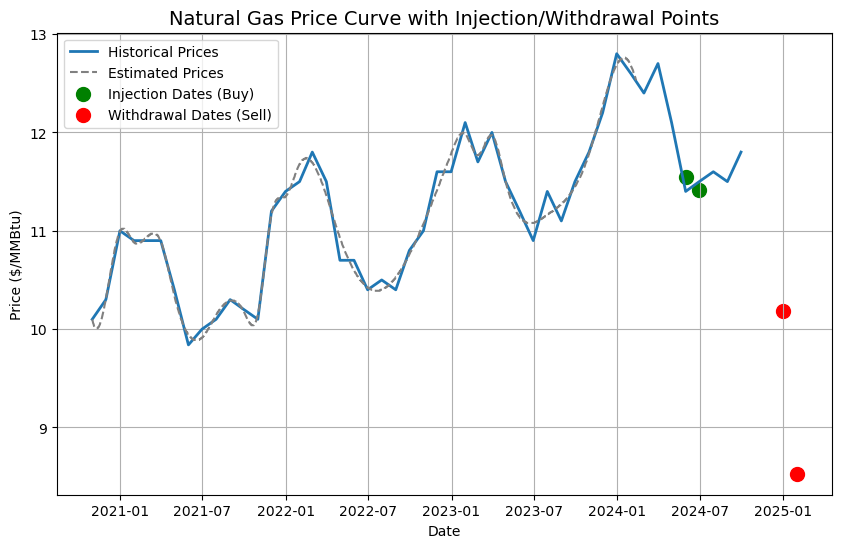

In [8]:
visualize_contract(df, injection_dates, withdrawal_dates)